In [ ]:
!pip install tensorflow-io

In [2]:
# importing the dependencies

import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
# connecting the colab with the drive to import the data

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# using the zipfile module to extract the data
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Audio_Classification_Data/Data.zip') as z:
  z.extractall()

In [5]:
def load_wav_16k_mono(filename):

  # reading the contents of the file
  file_contents = tf.io.read_file(filename)

  # decoding the audio file and setting the desired_channels as 1(this will give the mono-audio)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)

  # using squeeze to make the wav in 1 dimension
  wav = tf.squeeze(wav, axis = -1)

  # changing the datatype to integer
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)

  # changing the wavelength of the data from 48000 to 16000
  wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
  return  wav

In [6]:
# loading the function load_wav_16k_mono into 2 examples
CAPUCHIN_FILE = os.path.join('Data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('Data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

# calling on example from each classes
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

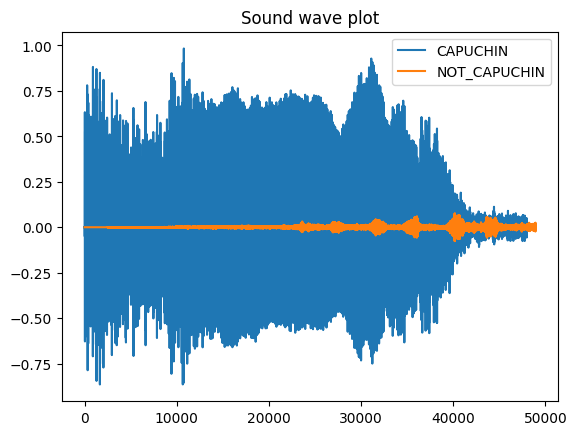

In [7]:
# plotting the soundwave
plt.plot(wave, label = "CAPUCHIN")
plt.plot(nwave, label = "NOT_CAPUCHIN")
plt.title("Sound wave plot")
plt.legend()
plt.show()

# Creating the TensorFlow dataset



In [8]:
# defiining the paths to positive and negative data
POS = os.path.join("Data", "Parsed_Capuchinbird_Clips")
NEG = os.path.join("Data", "Parsed_Not_Capuchinbird_Clips")

In [9]:
# listing all the files of '.wav' format into their respective features.
pos = tf.data.Dataset.list_files(POS+"/*.wav")
neg = tf.data.Dataset.list_files(NEG+"/*.wav")

In [10]:
# adding the labels
"""
1 : if the data is from Parsed_Capuchinbird
0 : if the data is from Parsed_Not_Capuchinbird
"""
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

# concating both positive and negative data
data = positives.concatenate(negatives)

# Determing the average length of a Capuchin Bird call

In [11]:
# recording the lengths of all the files
lengths = []
for file in os.listdir(os.path.join("Data", "Parsed_Capuchinbird_Clips")):
  tensor_wave = load_wav_16k_mono(os.path.join("Data", "Parsed_Capuchinbird_Clips", file))
  lengths.append(len(tensor_wave))

In [12]:
# Average wavelength of the data
print(f"Average wavelength of the data is {tf.math.reduce_mean(lengths)}")

Average wavelength of the data is 54156


In [13]:
# Maximum wavelength of the data
print(f"Maxmium wavelength of the file in data is {tf.math.reduce_max(lengths)}")

Maxmium wavelength of the file in data is 80000


In [14]:
# Minimum wavelength of the data
print(f"Minimum wavelength of the file in data is {tf.math.reduce_min(lengths)}")

Minimum wavelength of the file in data is 32000


Preprocessing the whole data set

In [15]:
# Preprocess function for the data
def preprocess(file_path, label):

  # converting the files into the suitable wavelength
  wav = load_wav_16k_mono(file_path)

  # taking the first 3 secs data
  wav = wav[:48000]

  # applying pre-padding if the data is less than the required 3 sec
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
  wav = tf.concat([zero_padding, wav], 0)

  # creating a spectogram
  spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)

  # converting all the negative values into positive values
  spectogram = tf.abs(spectogram)

  """
  adding an extra dimension in the last of the 2 dimensional data, so that we can use
  convolutional layers
  """
  spectogram = tf.expand_dims(spectogram, axis = 2)
  return spectogram, label

In [16]:
# testing the function on a single example

filepath, label = positives.shuffle(10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

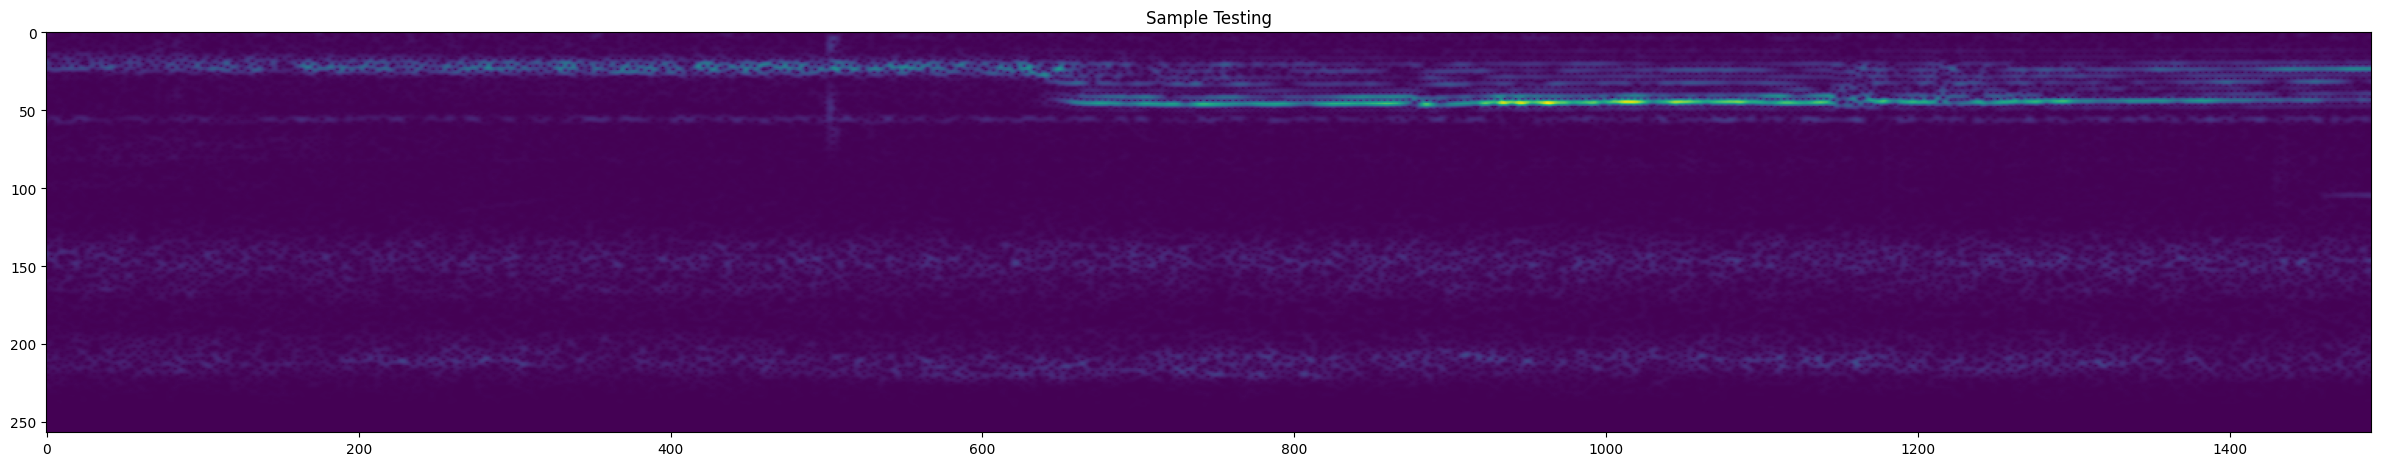

In [17]:
# plotting the wave
plt.figure(figsize = (30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title("Sample Testing")
plt.show()

# Creating a TensorFlow pipeline

In [18]:
# applying the preprocess function on the whole dataset
data = data.map(preprocess)

# caching the data
data = data.cache()

# applying the shuffle
data = data.shuffle(buffer_size = 1000)

# making batches of 16
data = data.batch(16)
data = data.prefetch(8)

In [19]:
print(f"Length of the whole dataset after applying the batch is {len(data)}")

Length of the whole dataset after applying the batch is 51


# Splitting the data into train and test dataset

In [20]:
"""
Taking the first 36 examples in the training set
Rest 15 examples are taking in the testing set
"""
train = data.take(36)
test = data.skip(36).take(15)

In [21]:
# taking an example from the training set
samples, labels = train.as_numpy_iterator().next()

In [22]:
print(f"Shape of an example from the training dataset {samples.shape}")

Shape of an example from the training dataset (16, 1491, 257, 1)


Building the TensorFlow Model

In [23]:
# importing the additional dependencies for DL model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

In [24]:
# initializing the Sequential API
model = Sequential([])

# first CNN layer with maxpooling
model.add(Conv2D(16, (3, 3), activation = "relu", input_shape = (1491, 257, 1)))
model.add(MaxPool2D(2, 2))

# second CNN layer with maxpooling
model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D(2, 2))

# flattening the tensor
model.add(Flatten())

# fully connected layer
model.add(Dense(128))

# using the Dropout layer with the probability of 0.2
model.add(Dropout(0.2))

# last layer with single neuron and activation set as "sigmoid"
model.add(Dense(1, activation = "sigmoid"))

In [25]:
# compiling the model with Adam optimizer
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 743, 126, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 63, 32)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 747936)            0         
                                                                 
 dense (Dense)               (None, 128)               9

In [27]:
# trainig the model on 4 epochs
hist = model.fit(train,
                 epochs = 4,
                 validation_data = test)

Epoch 1/4
36/36 [==============================] - 11s 127ms/step - loss: 7.7774 - recall: 0.8212 - precision: 0.8158 - val_loss: 0.1635 - val_recall: 0.9552 - val_precision: 0.9697
Epoch 2/4
36/36 [==============================] - 4s 113ms/step - loss: 0.0826 - recall: 0.9673 - precision: 0.9737 - val_loss: 0.0426 - val_recall: 1.0000 - val_precision: 0.9848
Epoch 3/4
36/36 [==============================] - 4s 108ms/step - loss: 0.0128 - recall: 0.9874 - precision: 0.9937 - val_loss: 0.0041 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 4s 102ms/step - loss: 0.0046 - recall: 0.9932 - precision: 1.0000 - val_loss: 0.0047 - val_recall: 1.0000 - val_precision: 1.0000


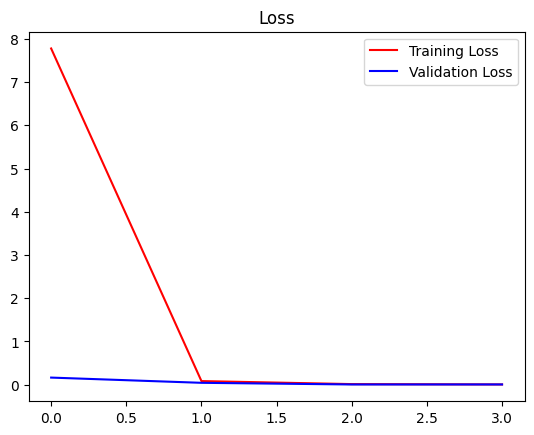

In [28]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label = "Training Loss")
plt.plot(hist.history['val_loss'], 'b', label = "Validation Loss")
plt.legend()
plt.show()

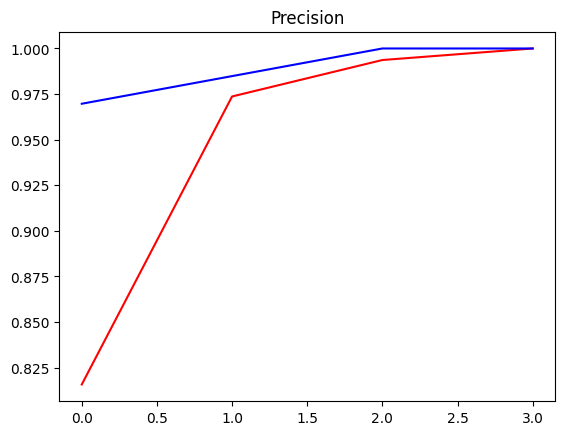

In [29]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label = "Training Precision")
plt.plot(hist.history['val_precision'], 'b', label = "Validation Precision")
plt.show()

Making a Predictiion of a single clip

In [30]:
# taking a single batch from the test set
x_test, y_test = test.as_numpy_iterator().next()

# predicitng y_hat from x_test dataset
y_hat = model.predict(x_test)

1/1 [==============================] - 0s 150ms/step


In [31]:
# converting logits to class
y_hat = [1 if prediction > 0.5 else 0 for prediction in y_hat]

In [32]:
print(y_hat)

[0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0]


Build Forest Parsing Function

In [33]:
# loading the mp3 data
def load_mp3_16k_mono(filename):

  # loading the mp3 file
  res = tfio.audio.AudioIOTensor(filename)

  # converting it into the tensor
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis = 1)/2

  # extracting the sample rate and cast
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)

  # resampling to 16 kHz
  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = 16000)

  return wav

In [34]:
# taking a path of single mp3 file
mp3 = os.path.join("Data", "Forest Recordings", "recording_03.mp3")

# passing it through the load_mp3_16k_mono function
wav = load_mp3_16k_mono(mp3)

In [35]:
# creating a time-series dataset from audio data with specified parameters
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length = 48000, sequence_stride = 48000, batch_size = 1)

# retrieving the first batch of samples and corresponding indices from the dataset
samples, index = audio_slices.as_numpy_iterator().next()

In [36]:
print(f"Shape of the Sample is {samples.shape}")

Shape of the Sample is (1, 48000)


In [37]:
print(f"Shape of the Index is {index.shape}")

Shape of the Index is (1,)


Building Function to Convert Clips into windowed Spectograms

In [38]:
# making a function to preprocess the mp3
def preprocess_mp3(sample, index):
  sample = sample[0]

  # padding the samples to make sure that all the recordings are of same length
  zero_padding = tf.zeros([48000] - tf.shape(sample), dtype = tf.float32)

  # concating the both padded and samples
  wav = tf.concat([zero_padding, sample], 0)

  # making a spectogram
  spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)

  # taking the absolute values
  spectrogram = tf.abs(spectrogram)

  # making the spectogram into 3D so that Conv2D layers can be used
  spectrogram = tf.expand_dims(spectrogram, axis = 2)
  return spectrogram

In [39]:
# again creating a time-series dataset from audio data with specified parameters
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length = 16000, sequence_stride = 16000, batch_size = 1)

# applying preprocessing function to each element in the dataset
audio_slices = audio_slices.map(preprocess_mp3)

# batch the preprocessed dataset with a batch size of 64
audio_slices = audio_slices.batch(64)

In [40]:
# making the predictions using the trained model
yhat = model.predict(audio_slices)

# changing the output into binary values
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 4s 694ms/step


Group Consecutive Detections

In [41]:
from itertools import groupby

In [42]:
# grouping consecutive elements in yhat using groupby
yhat = [key for key, group in groupby(yhat)]

# counting the total number of positive predictions
calls = tf.math.reduce_sum(yhat).numpy()

In [43]:
print(f"Total number of the output in the taken sample is {calls}")

Total number of the output in the taken sample is 0


Make Predictions

In [44]:
results = {}

# iterating through all the recordings
for file in os.listdir(os.path.join("Data", "Forest Recordings")):
  FILEPATH = os.path.join("Data", "Forest Recordings", file)

  # loading the audio files and creating a time series dataset
  wav = load_mp3_16k_mono(FILEPATH)
  audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length = 48000, sequence_stride = 48000, batch_size = 1)

  # applying preprocessing and then baching it
  audio_slices = audio_slices.map(preprocess_mp3)
  audio_slices = audio_slices.batch(64)

  # now making the predictions
  yhat = model.predict(audio_slices)

  # adding the result of each file in a dictionary
  results[file] = yhat

1/1 [==============================] - 0s 406ms/step


Convert Predictions into Class

In [45]:
class_preds = {}

for file, logits in results.items():
   # threshold logits to obtain binary class predictions and store them in class_preds dictionary
  class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
print(class_preds)

{'recording_42.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_67.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_32.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'recording_30.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'recording_58.mp3': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [46]:
postprocessed = {}
for file, scores in class_preds.items():

  # grouping consecutive elements and calculating their sum
  postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()

print(postprocessed)

{'recording_42.mp3': 0, 'recording_67.mp3': 0, 'recording_32.mp3': 2, 'recording_30.mp3': 1, 'recording_58.mp3': 0, 'recording_19.mp3': 2, 'recording_37.mp3': 4, 'recording_47.mp3': 16, 'recording_44.mp3': 1, 'recording_72.mp3': 12, 'recording_05.mp3': 0, 'recording_60.mp3': 5, 'recording_61.mp3': 15, 'recording_12.mp3': 0, 'recording_98.mp3': 21, 'recording_01.mp3': 0, 'recording_71.mp3': 10, 'recording_10.mp3': 5, 'recording_97.mp3': 4, 'recording_09.mp3': 0, 'recording_08.mp3': 24, 'recording_56.mp3': 15, 'recording_59.mp3': 15, 'recording_48.mp3': 10, 'recording_64.mp3': 3, 'recording_35.mp3': 0, 'recording_17.mp3': 3, 'recording_70.mp3': 4, 'recording_22.mp3': 2, 'recording_03.mp3': 0, 'recording_69.mp3': 1, 'recording_92.mp3': 8, 'recording_91.mp3': 0, 'recording_68.mp3': 1, 'recording_06.mp3': 12, 'recording_50.mp3': 0, 'recording_21.mp3': 1, 'recording_34.mp3': 4, 'recording_25.mp3': 15, 'recording_57.mp3': 3, 'recording_73.mp3': 0, 'recording_45.mp3': 4, 'recording_07.mp3': 2,

In [47]:
import csv

In [48]:
# saving the output in a csv file using the csv module
with open('results.csv', 'w', newline = '') as f:
  writer = csv.writer(f, delimiter = ',')
  writer.writerow(['recording', 'capuchin_calls'])
  for key, value in postprocessed.items():
    writer.writerow([key, value])